# **Imports**


In [43]:
# IMPORTS

import numpy as np
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from PIL import Image

# **Load Data**

In [44]:
# LOAD_DATA

transform = transforms.ToTensor()
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# **Preprocessing**

In [45]:
# PROCESS DATA

X_train_full = trainset.data.numpy().reshape(trainset.data.shape[0], -1) / 255.0
y_train_full = trainset.targets.numpy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

X_test = testset.data.numpy().reshape(testset.data.shape[0], -1) / 255.0
y_test = testset.targets.numpy()

def one_hot_encode(y, num_classes):
  one_hot = np.zeros((len(y), num_classes))
  one_hot[np.arange(len(y)), y] = 1
  return one_hot

y_train = one_hot_encode(y_train, 10)
y_val = one_hot_encode(y_val, 10)
y_test = one_hot_encode(y_test, 10)

# Layers
1. Dense Layer
2. ReLu
3. SoftMax
4. Batch Normalization
5. Adam Optimizer
6. Dropout

In [46]:
class Layer:
    """
    Base class for layers.
    """
    def __init__(self):
        self.input = None
        self.output = None

    def forward_propagation(self, input):
        """
        Forward propagation function.
        """
        raise NotImplementedError

    def backward_propagation(self, output_gradient):
        """
        Backward propagation function.
        """
        raise NotImplementedError


# MODEL COMPONENTS

class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        # self.weights = np.random.randn(output_size, input_size) * np.sqrt(2.0 / (input_size + output_size)) # xavier initialization
        self.weight_matrix = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)   # He initialization
        self.bias_vector = np.zeros((1, output_size))

        # Placeholders for intermediate computations
        self.input_data = None
        self.gradient_weights = None
        self.gradient_biases = None

    def forward(self, inputs, is_training=True):
        """
        Compute the output using: output = inputs * weights + bias
        """
        self.input_data = inputs  # Storing input for backpropagation use
        output = np.dot(inputs, self.weight_matrix) + self.bias_vector
        return output

    def backward(self, gradient_out):
        """
        Perform backward pass and calculate gradients:
        - Gradient with respect to weights and biases
        - Return the gradient with respect to the input data
        """
        # Gradient of weights and biases calculation
        self.gradient_weights = np.dot(self.input_data.T, gradient_out)
        self.gradient_biases = np.sum(gradient_out, axis=0, keepdims=True)

        # Returning gradient for the previous layer
        gradient_input = np.dot(gradient_out, self.weight_matrix.T)
        return gradient_input


class BatchNormalizationLayer(Layer):
    def __init__(self, feature_dim, momentum=0.9, epsilon=1e-5):
        super().__init__()
        # Parameters for scaling and shifting
        self.scale = np.ones((1, feature_dim))  # Equivalent to gamma
        self.shift = np.zeros((1, feature_dim))  # Equivalent to beta
        self.momentum = momentum
        self.epsilon = epsilon

        # Running statistics for inference mode
        self.moving_mean = np.zeros((1, feature_dim))
        self.moving_variance = np.ones((1, feature_dim))

        # Caches for backpropagation
        self.normalized_input = None
        self.input_data = None
        self.mean_batch = None
        self.variance_batch = None

    def forward(self, inputs, is_training=True):
        """
        Forward pass for batch normalization.
        """
        if is_training:
            # Compute mean and variance for the batch
            self.mean_batch = np.mean(inputs, axis=0, keepdims=True)
            self.variance_batch = np.var(inputs, axis=0, keepdims=True) + self.epsilon  # Adding epsilon to prevent division by zero

            # Normalize the input
            self.normalized_input = (inputs - self.mean_batch) / np.sqrt(self.variance_batch)
            self.input_data = inputs

            # Update running mean and variance for inference
            self.moving_mean = self.momentum * self.moving_mean + (1 - self.momentum) * self.mean_batch
            self.moving_variance = self.momentum * self.moving_variance + (1 - self.momentum) * self.variance_batch
        else:
            # Use the moving mean and variance for normalization during inference
            self.normalized_input = (inputs - self.moving_mean) / np.sqrt(self.moving_variance + self.epsilon)

        # Scale and shift the normalized input
        return self.scale * self.normalized_input + self.shift

    def backward(self, gradient_out):
        """
        Backward pass for batch normalization to calculate gradients.
        """
        batch_size = gradient_out.shape[0]

        # Gradients with respect to normalized input
        grad_normalized = gradient_out * self.scale

        # Gradient with respect to variance
        grad_variance = np.sum(grad_normalized * (self.input_data - self.mean_batch) * -0.5 * (self.variance_batch ** -1.5), axis=0, keepdims=True)

        # Gradient with respect to mean
        grad_mean = (np.sum(grad_normalized * -1 / np.sqrt(self.variance_batch), axis=0, keepdims=True) +
                     grad_variance * np.mean(-2 * (self.input_data - self.mean_batch), axis=0, keepdims=True))

        # Gradient with respect to input
        grad_input = (grad_normalized / np.sqrt(self.variance_batch) +
                      grad_variance * 2 * (self.input_data - self.mean_batch) / batch_size +
                      grad_mean / batch_size)

        # Gradients for scale and shift
        self.grad_scale = np.sum(gradient_out * self.normalized_input, axis=0, keepdims=True)
        self.grad_shift = np.sum(gradient_out, axis=0, keepdims=True)

        return grad_input


class ReLUActivation(Layer):
    def __init__(self):
        super().__init__()
        # Mask to keep track of positive input elements during the forward pass
        self.activation_mask = None

    def forward(self, inputs, is_training=True):
        """
        Forward pass for ReLU activation: Outputs the input if positive, otherwise zero.
        """
        self.activation_mask = inputs > 0  # Boolean mask for positive inputs
        return inputs * self.activation_mask

    def backward(self, gradient_out):
        """
        Backward pass for ReLU activation: Passes gradient only through positive input regions.
        """
        return gradient_out * self.activation_mask


class DropoutLayer(Layer):
    def __init__(self, drop_rate=0.5):
        super().__init__()
        """
        Initializes the dropout layer.
        drop_rate: The probability of dropping a node during training.
        """
        self.drop_rate = drop_rate
        self.dropout_mask = None

    def forward(self, inputs, is_training=True):
        """
        Forward pass for dropout. Drops nodes at the specified rate during training.
        """
        if is_training:
            # Create a mask with the probability of retaining a node as (1 - drop_rate)
            self.dropout_mask = (np.random.rand(*inputs.shape) > self.drop_rate) / (1 - self.drop_rate)
            return inputs * self.dropout_mask
        return inputs  # During inference, no dropout is applied

    def backward(self, gradient_out):
        """
        Backward pass for dropout: Scales the gradient by the dropout mask.
        """
        return gradient_out * self.dropout_mask


class AdamOptimizer(Layer):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__()
        """
        Initializes the Adam optimizer with the specified parameters.
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum = {}
        self.velocity = {}
        self.step_count = 0

    def update_parameters(self, parameters, gradients):
        """
        Updates the parameters using the Adam optimization algorithm.
        """
        if not self.momentum:
            for param_name in parameters:
                self.momentum[param_name] = np.zeros_like(parameters[param_name])
                self.velocity[param_name] = np.zeros_like(parameters[param_name])

        self.step_count += 1

        for param_name in parameters:
            # Update biased first and second moment estimates
            self.momentum[param_name] = (self.beta1 * self.momentum[param_name] +
                                         (1 - self.beta1) * gradients[param_name])
            self.velocity[param_name] = (self.beta2 * self.velocity[param_name] +
                                         (1 - self.beta2) * (gradients[param_name] ** 2))

            # Compute bias-corrected moment estimates
            corrected_momentum = self.momentum[param_name] / (1 - self.beta1 ** self.step_count)
            corrected_velocity = self.velocity[param_name] / (1 - self.beta2 ** self.step_count)

            # Parameter update step
            parameters[param_name] -= self.lr * corrected_momentum / (np.sqrt(corrected_velocity) + self.epsilon)


class SoftmaxActivation(Layer):
    def __init__(self, drop_rate=0.5):
        super().__init__()
        """
        Initializes the Softmax Activation layer.
        drop_rate: The probability of dropping a node during training.
        """

    def forward(self, inputs, is_training=True):
        """
        Forward pass for softmax activation. Normalizes the input array to represent probabilities.
        """
        shifted_inputs = inputs - np.max(inputs, axis=1, keepdims=True)  # Stability improvement for large inputs
        exp_inputs = np.exp(shifted_inputs)
        self.output = exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)
        return self.output

    def backward(self, target_labels):
        """
        Backward pass for softmax activation during training.
        """
        num_samples = target_labels.shape[0]
        return (self.output - target_labels) / num_samples


# **Neural Network Models**

In [47]:
class NeuralNetworkDynamic:
    def __init__(self, layer_specs, learning_rate):
        """
        Initialize a dynamic neural network.

        layer_specs: A list of dictionaries where each dictionary defines a layer with:
            - 'type': The type of the layer (e.g., 'Dense', 'ReLU', 'Softmax', etc.)
            - 'params': The parameters for the layer (e.g., input/output dimensions)
        learning_rate: The learning rate for the optimizer.
        """
        self.layers = []
        for spec in layer_specs:
            layer_type = spec['type']
            params = spec['params']

            if layer_type == 'Dense':
                self.layers.append(DenseLayer(params['input_dim'], params['output_dim']))
            elif layer_type == 'ReLU':
                self.layers.append(ReLUActivation())
            elif layer_type == 'BatchNorm':
                self.layers.append(BatchNormalizationLayer(params['dim']))
            elif layer_type == 'Dropout':
                self.layers.append(DropoutLayer(params['rate']))
            elif layer_type == 'Softmax':
                self.layers.append(SoftmaxActivation())
            else:
                raise ValueError(f"Unsupported layer type: {layer_type}")

        # Initialize the optimizer
        self.optimizer = AdamOptimizer(learning_rate)
    def state_dict(self):
        """
        Collects and returns the model parameters (weights and biases) in a dictionary.
        """
        state = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                state[f'layer{i}_weights'] = layer.weight_matrix
                state[f'layer{i}_bias'] = layer.bias_vector
        return state

    def forward(self, inputs, is_training=True):
        """
        Forward pass through all layers in the network.
        """
        x = inputs
        for layer in self.layers:
            x = layer.forward(x, is_training)
        return x

    def backward(self, targets):
        """
        Backward pass through all layers in reverse order and update parameters.
        """
        grad = targets
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        # Collect parameters and gradients for updating
        parameters = {}
        gradients = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                parameters[f'layer{i}_w'] = layer.weight_matrix
                parameters[f'layer{i}_b'] = layer.bias_vector
                gradients[f'layer{i}_w'] = layer.gradient_weights
                gradients[f'layer{i}_b'] = layer.gradient_biases
            elif isinstance(layer, BatchNormalizationLayer):
                parameters[f'layer{i}_gamma'] = layer.scale
                parameters[f'layer{i}_beta'] = layer.shift
                gradients[f'layer{i}_gamma'] = layer.grad_scale
                gradients[f'layer{i}_beta'] = layer.grad_shift

        self.optimizer.update_parameters(parameters, gradients)

# Example usage to create NN1 and NN2 using the dynamic class
nn1_specs = [
    {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 128}},
    {'type': 'ReLU', 'params': {}},
    {'type': 'Dense', 'params': {'input_dim': 128, 'output_dim': 10}},
    {'type': 'Softmax', 'params': {}}
]

nn2_specs = [
    {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 256}},
    {'type': 'ReLU', 'params': {}},
    {'type': 'Dense', 'params': {'input_dim': 256, 'output_dim': 128}},
    {'type': 'ReLU', 'params': {}},
    {'type': 'Dense', 'params': {'input_dim': 128, 'output_dim': 10}},
    {'type': 'Softmax', 'params': {}}
]

# Initialize networks with their specifications and a learning rate
nn1 = NeuralNetworkDynamic(nn1_specs, learning_rate=0.001)
nn2 = NeuralNetworkDynamic(nn2_specs, learning_rate=0.001)


# **Training ans Testing Functions**

In [48]:
# TRAIN FUNCTION
def train(model, X_train, y_train, X_val, y_val, batch_size=128, epochs=10):
    """
    Train the model using the provided training and validation data.
    """
    train_losses = []
    val_losses = []
    n_batches = len(X_train) // batch_size

    for epoch in range(epochs):
        # Shuffle training data at the start of each epoch
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        epoch_train_loss = 0

        for batch_index in range(n_batches):
            start = batch_index * batch_size
            end = start + batch_size

            # Create mini-batch
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            # Forward pass through the model
            outputs = model.forward(X_batch, is_training=True)

            # Compute batch loss using cross-entropy
            batch_loss = -np.mean(np.sum(y_batch * np.log(outputs + 1e-7), axis=1))
            epoch_train_loss += batch_loss

            # Backward pass
            model.backward(y_batch)

        # Average training loss over all batches
        epoch_train_loss /= n_batches
        train_losses.append(epoch_train_loss)

        # Validation step
        val_outputs = model.forward(X_val, is_training=False)
        val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-7), axis=1))
        val_losses.append(val_loss)

        # Calculate training and validation accuracy
        train_acc = np.mean(np.argmax(outputs, axis=1) == np.argmax(y_batch, axis=1))
        val_acc = np.mean(np.argmax(val_outputs, axis=1) == np.argmax(y_val, axis=1))
        val_f1 = f1_score(np.argmax(y_val, axis=1), np.argmax(val_outputs, axis=1), average='macro')

        # Print formatted output for each epoch
        print(f"{epoch + 1} & {epoch_train_loss:.4f} & {train_acc:.4f} & {val_loss:.4f} & {val_acc:.4f} & {val_f1:.4f} \\\\")

    return train_losses, val_losses, train_acc, val_acc, val_f1

# TEST FUNCTION
def test(model, X_test, y_test):
    """
    Test the model using the provided test data.
    """
    # Forward pass
    test_outputs = model.forward(X_test, is_training=False)

    # Calculate test loss using cross-entropy
    test_loss = -np.mean(np.sum(y_test * np.log(test_outputs + 1e-7), axis=1))

    # Calculate test accuracy
    test_acc = np.mean(np.argmax(test_outputs, axis=1) == np.argmax(y_test, axis=1))

    # Confusion matrix
    y_pred = np.argmax(test_outputs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return test_loss, test_acc, conf_matrix


# **Train and Test - Generate Matrices**

In [ ]:
# TRAINING FUNCTION FOR DYNAMIC MODEL
learning_rates = [0.005, 0.0035, 0.002, 0.001]
batch_size = 128
epochs = 10

# Dictionary to store results for analysis and plotting
results = {}

for learning_rate in learning_rates:
    results[learning_rate] = {}

    # Define model architectures dynamically
    model_specs = [
        [
            {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 128}},
            {'type': 'ReLU', 'params': {}},
            {'type': 'Dense', 'params': {'input_dim': 128, 'output_dim': 10}},
            {'type': 'Softmax', 'params': {}}
        ],
        [
            {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 64}},
            {'type': 'BatchNorm', 'params': {'dim': 64}},
            {'type': 'ReLU', 'params': {}},
            {'type': 'Dropout', 'params': {'rate': 0.3}},
            {'type': 'Dense', 'params': {'input_dim': 64, 'output_dim': 32}},
            {'type': 'BatchNorm', 'params': {'dim': 32}},
            {'type': 'ReLU', 'params': {}},
            {'type': 'Dropout', 'params': {'rate': 0.3}},
            {'type': 'Dense', 'params': {'input_dim': 32, 'output_dim': 10}},
            {'type': 'Softmax', 'params': {}}
        ],
        # [
        #     {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 256}},
        #     {'type': 'ReLU', 'params': {}},
        #     {'type': 'Dense', 'params': {'input_dim': 256, 'output_dim': 128}},
        #     {'type': 'ReLU', 'params': {}},
        #     {'type': 'Dense', 'params': {'input_dim': 128, 'output_dim': 10}},
        #     {'type': 'Softmax', 'params': {}}
        # ],
        [
            {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 256}},
            {'type': 'BatchNorm', 'params': {'dim': 256}},
            {'type': 'ReLU', 'params': {}},
            {'type': 'Dropout', 'params': {'rate': 0.3}},
            {'type': 'Dense', 'params': {'input_dim': 256, 'output_dim': 128}},
            {'type': 'BatchNorm', 'params': {'dim': 128}},
            {'type': 'ReLU', 'params': {}},
            {'type': 'Dropout', 'params': {'rate': 0.3}},
            {'type': 'Dense', 'params': {'input_dim': 128, 'output_dim': 10}},
            {'type': 'Softmax', 'params': {}}
        ]
    ]

    # Create and train each model
    for i, spec in enumerate(model_specs, start=1):
        model = NeuralNetworkDynamic(spec, learning_rate)


        # Train the model
        train_losses, val_losses, train_acc, val_acc, val_f1 = train(
            model, X_train, y_train, X_val, y_val,
            batch_size=batch_size,
            epochs=epochs
        )

        print(f"\n\n model {i} {learning_rate}\n")
        print("-----------------------------------\n")

        # Store training results for this model
        results[learning_rate][f"Model {i}"] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_acc_history": train_acc,  # Store training accuracy for each epoch
            "val_acc_history": val_acc,      # Store validation accuracy for each epoch
            "val_f1_history": val_f1         # Store validation macro-F1 score for each epoch
        }

        # Test the model
        test_loss, test_acc, conf_matrix = test(model, X_test, y_test)

        # Store test results
        results[learning_rate][f"Model {i}"]["test_loss"] = test_loss
        results[learning_rate][f"Model {i}"]["test_acc"] = test_acc
        results[learning_rate][f"Model {i}"]["conf_matrix"] = conf_matrix


1 & 0.5221 & 0.7734 & 0.3923 & 0.8594 & 0.8579 \\
2 & 0.3905 & 0.8984 & 0.3829 & 0.8630 & 0.8630 \\
3 & 0.3552 & 0.8516 & 0.3831 & 0.8609 & 0.8626 \\
4 & 0.3320 & 0.8594 & 0.3573 & 0.8708 & 0.8682 \\
5 & 0.3170 & 0.8984 & 0.3438 & 0.8762 & 0.8745 \\
6 & 0.3026 & 0.8672 & 0.3305 & 0.8820 & 0.8804 \\
7 & 0.2913 & 0.9219 & 0.3364 & 0.8788 & 0.8801 \\
8 & 0.2809 & 0.8516 & 0.3307 & 0.8855 & 0.8849 \\
9 & 0.2724 & 0.8984 & 0.3385 & 0.8850 & 0.8857 \\
10 & 0.2668 & 0.8750 & 0.3251 & 0.8908 & 0.8909 \\


TypeError: unsupported operand type(s) for -: 'NeuralNetworkDynamic' and 'set'

# **Plot**

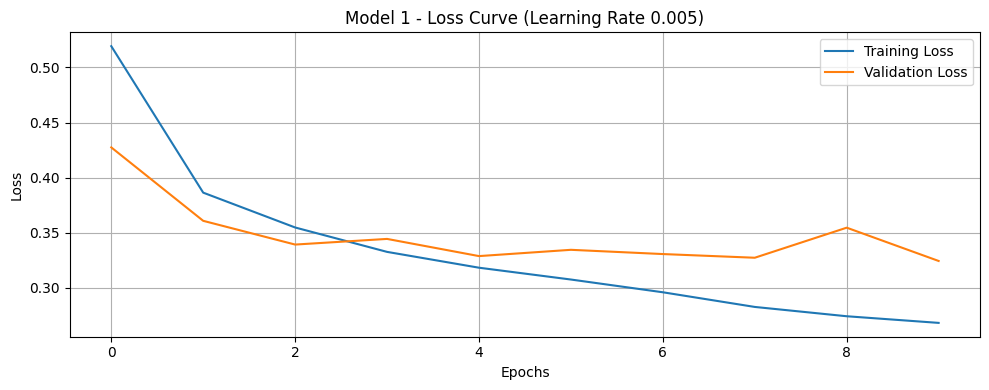

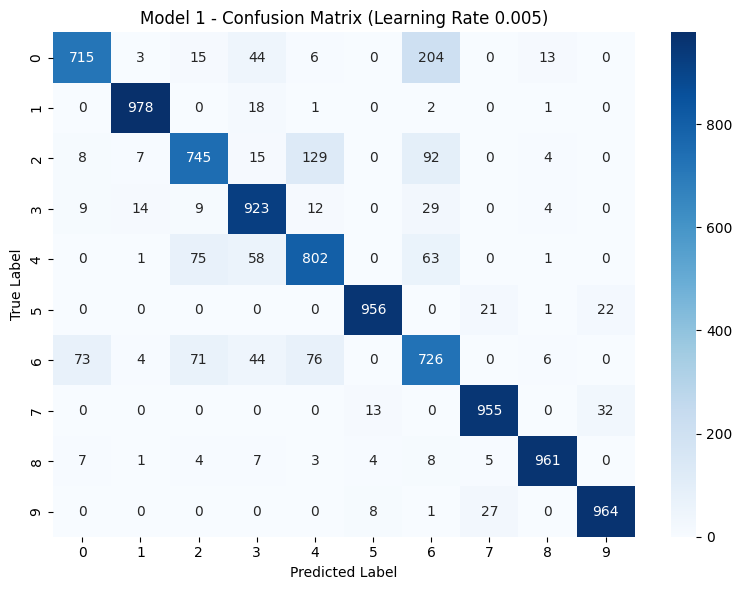

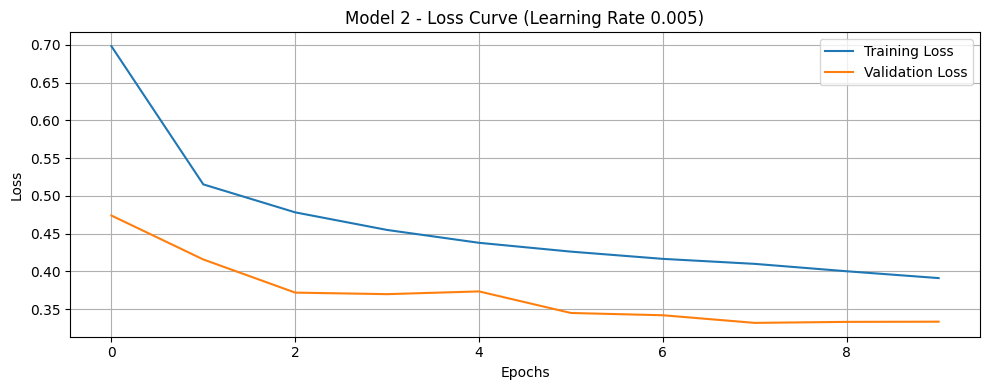

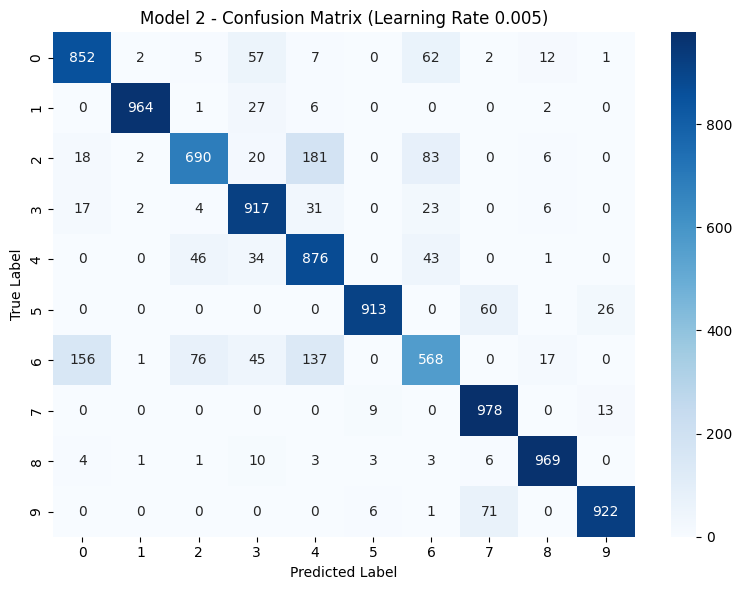

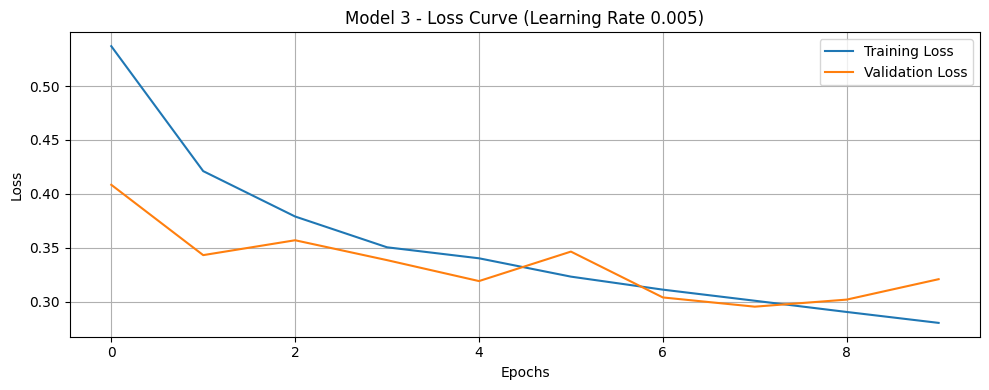

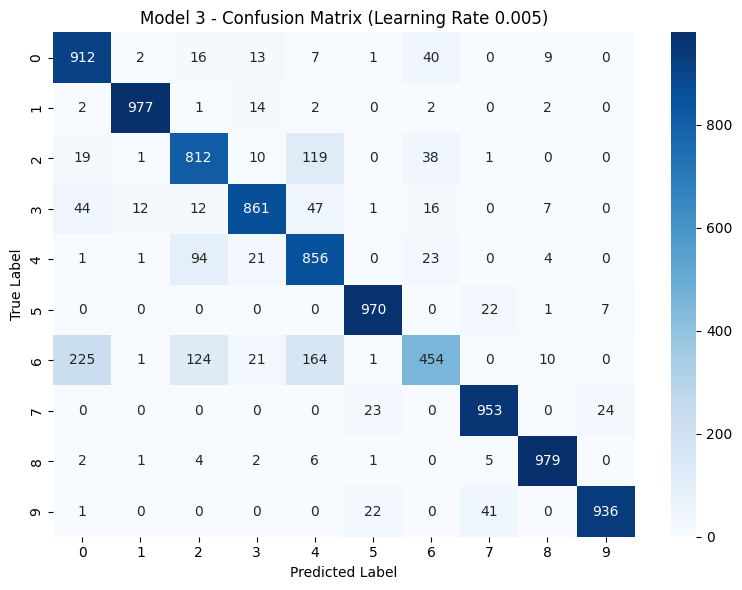

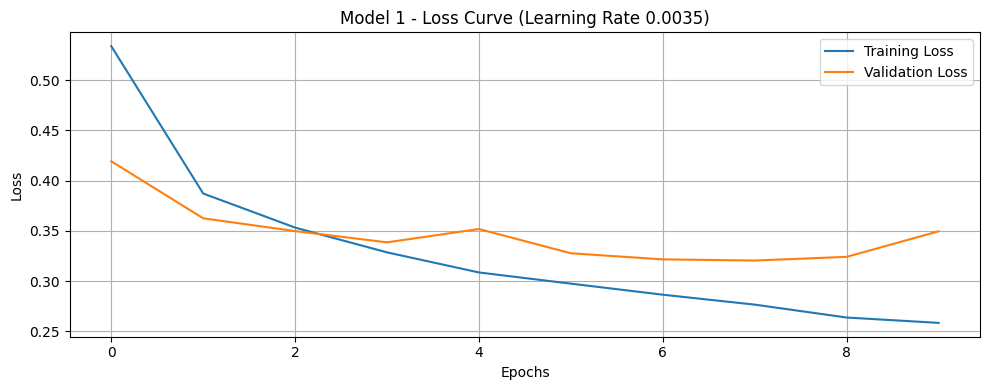

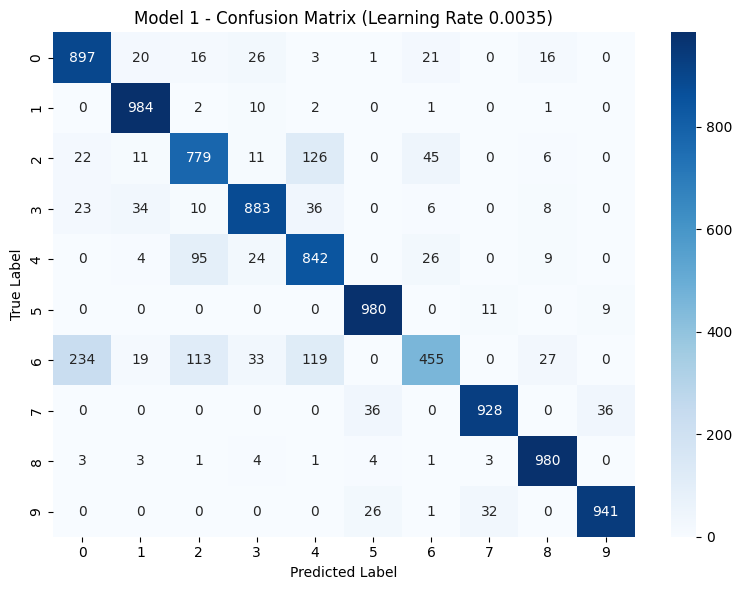

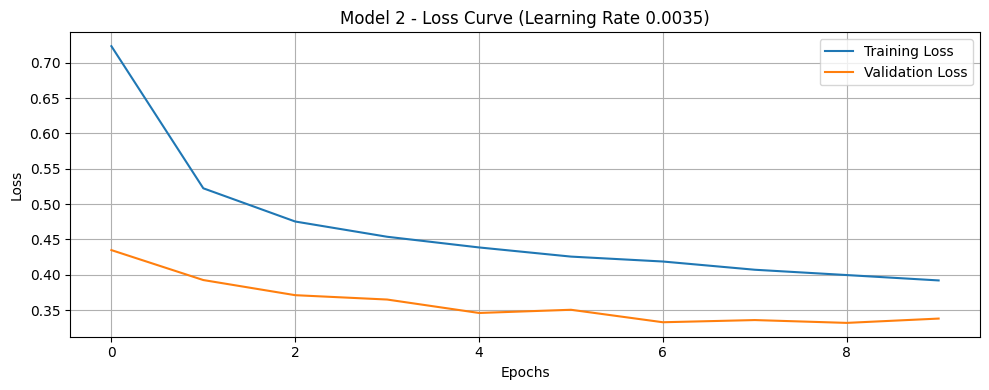

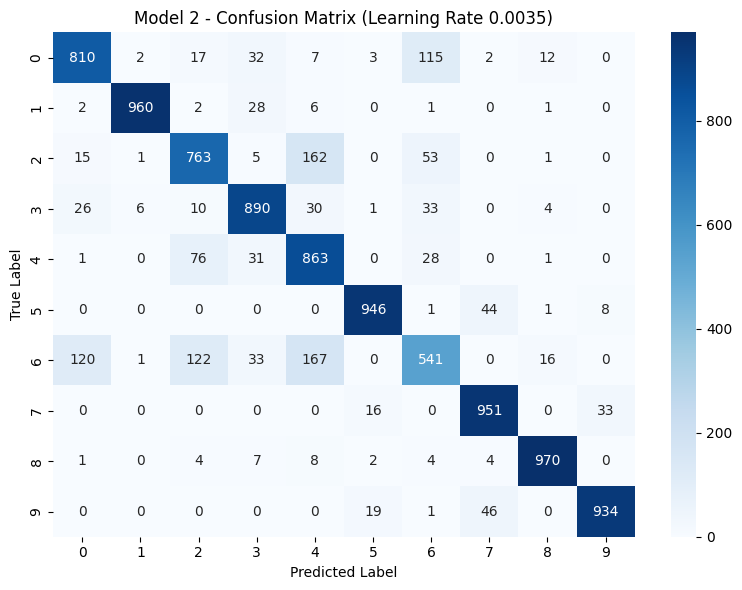

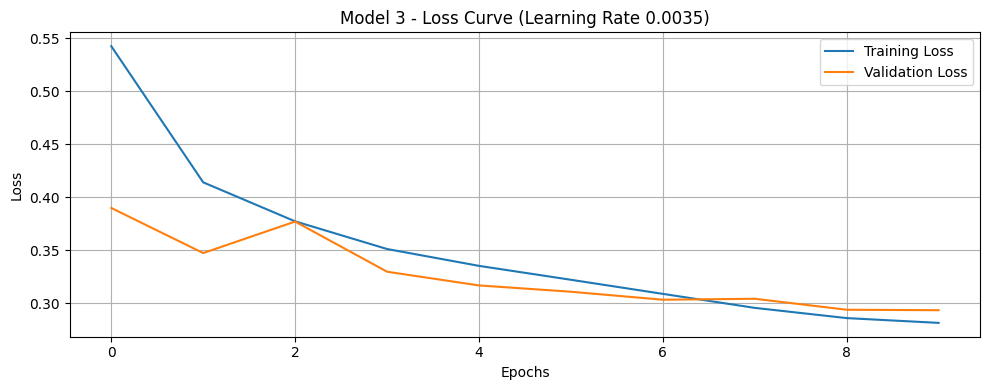

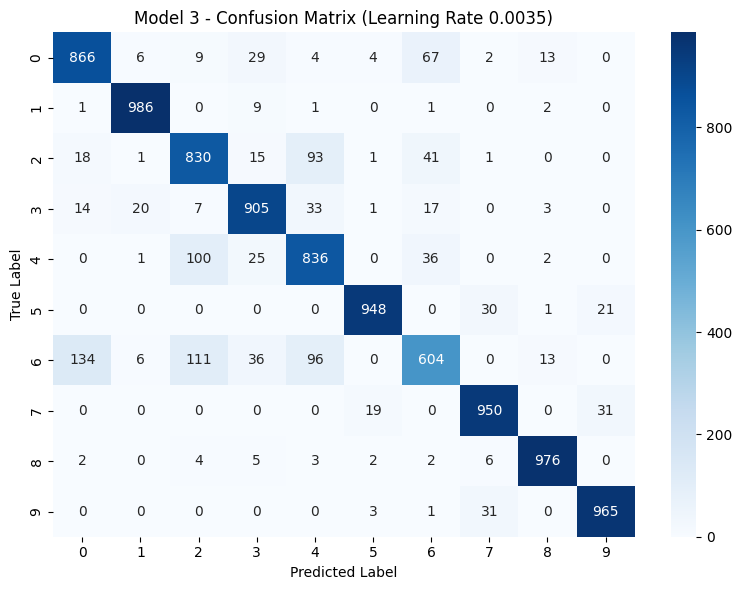

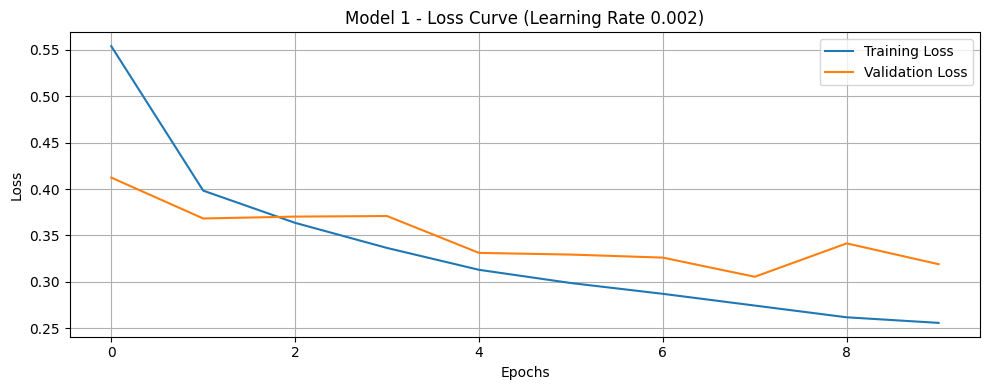

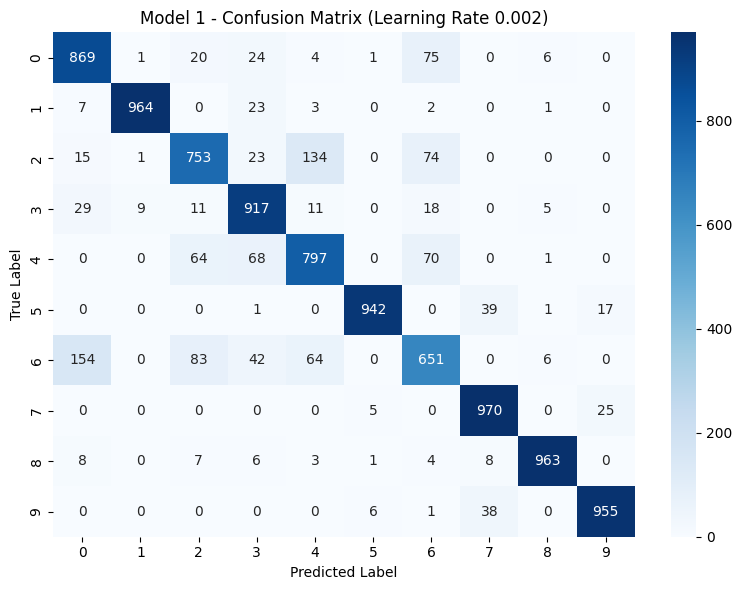

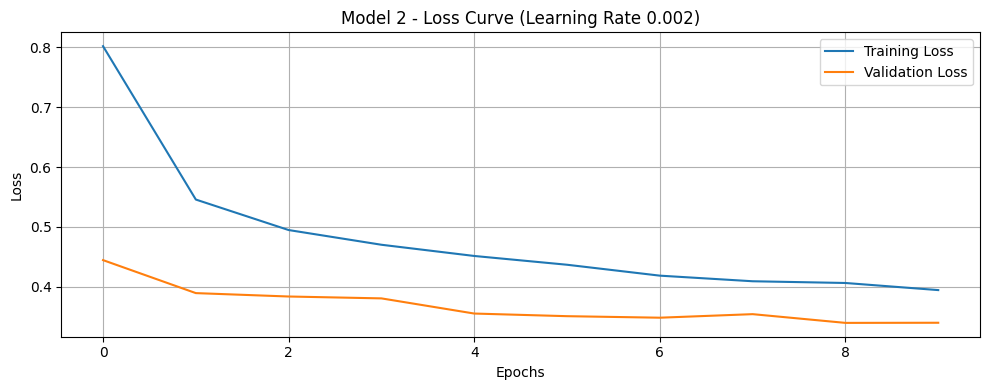

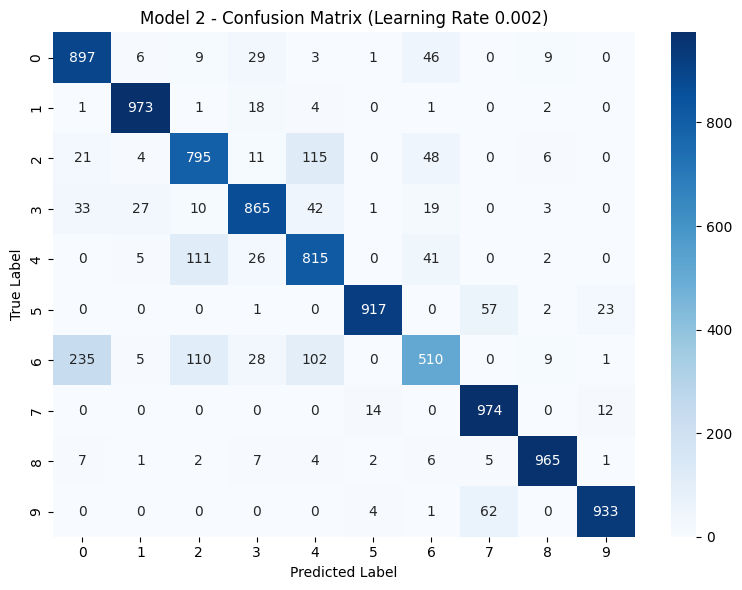

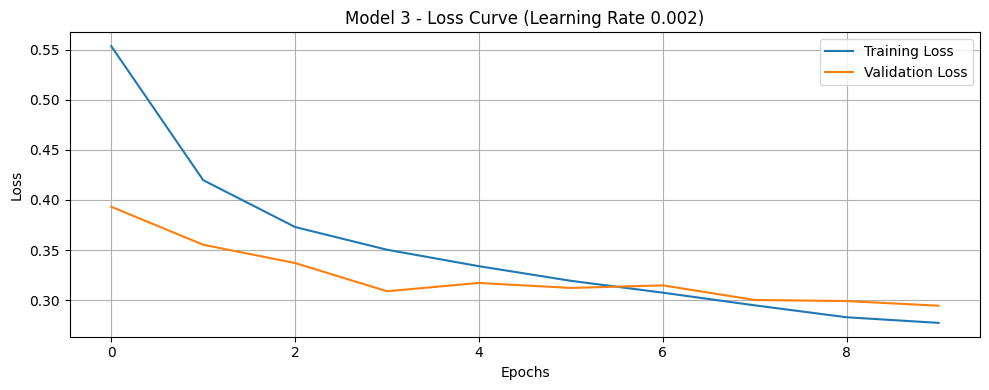

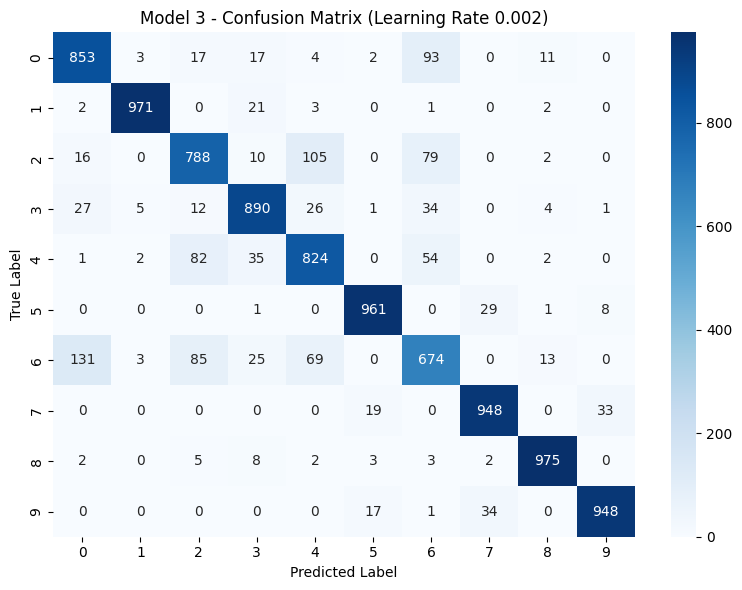

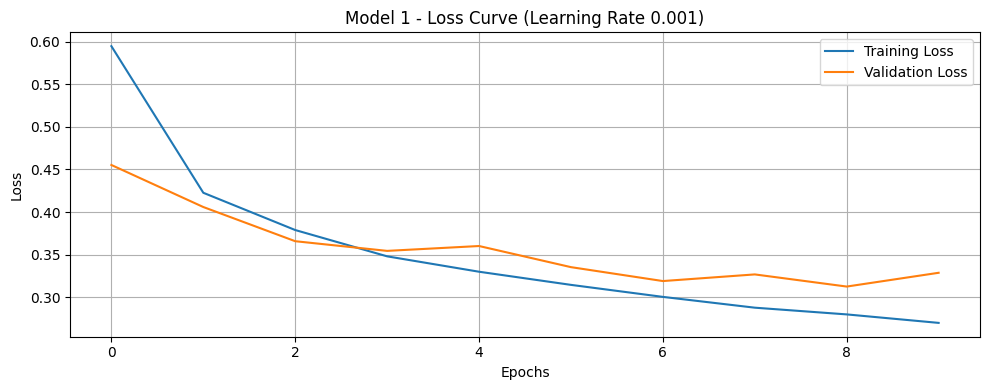

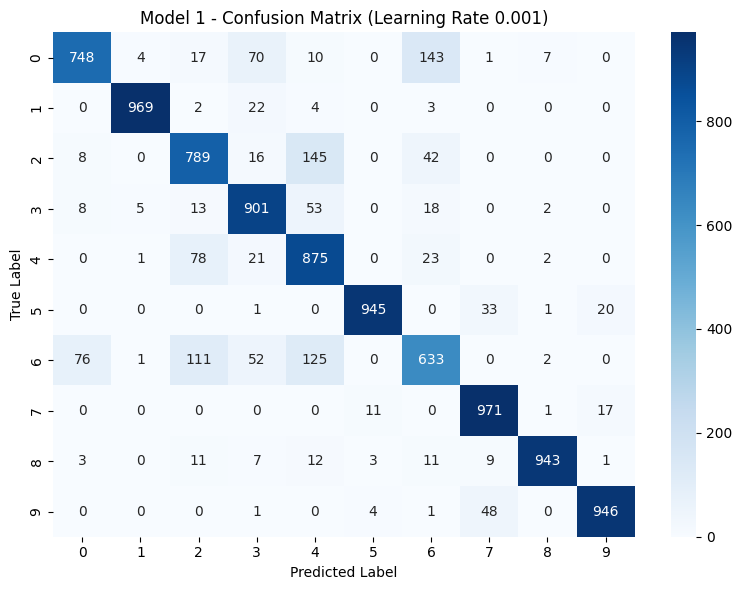

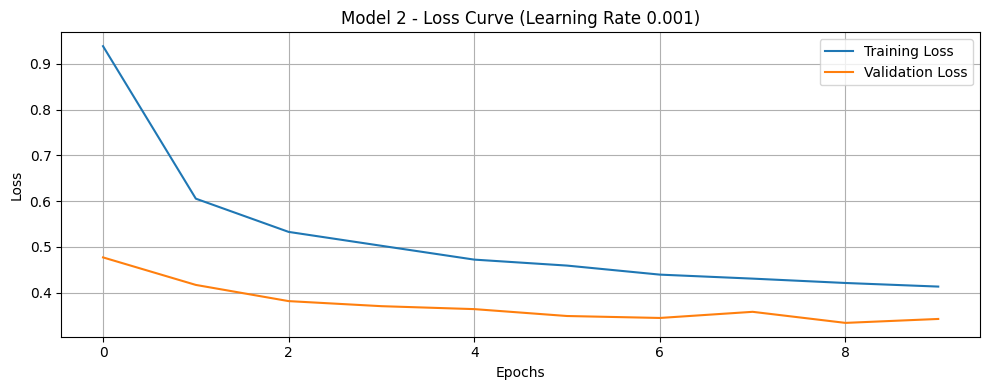

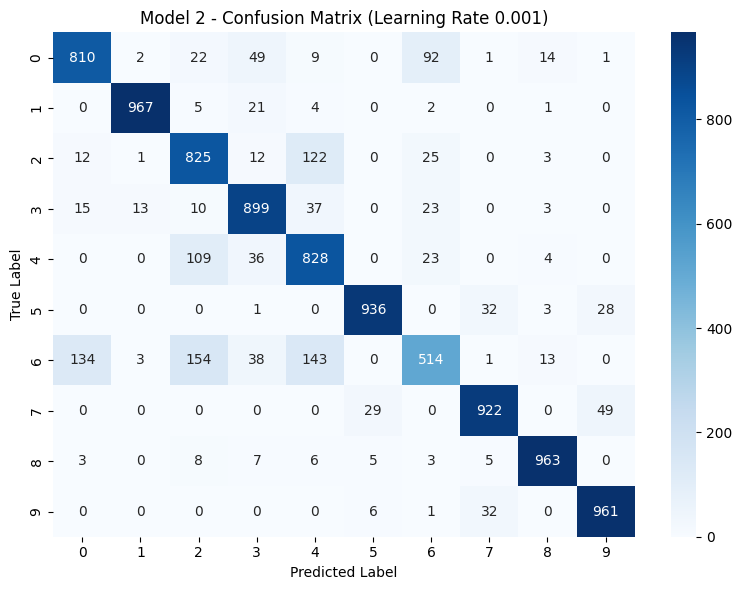

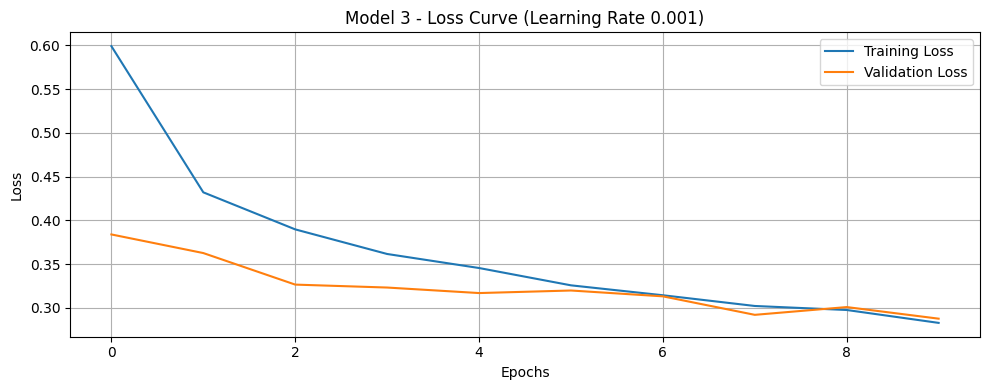

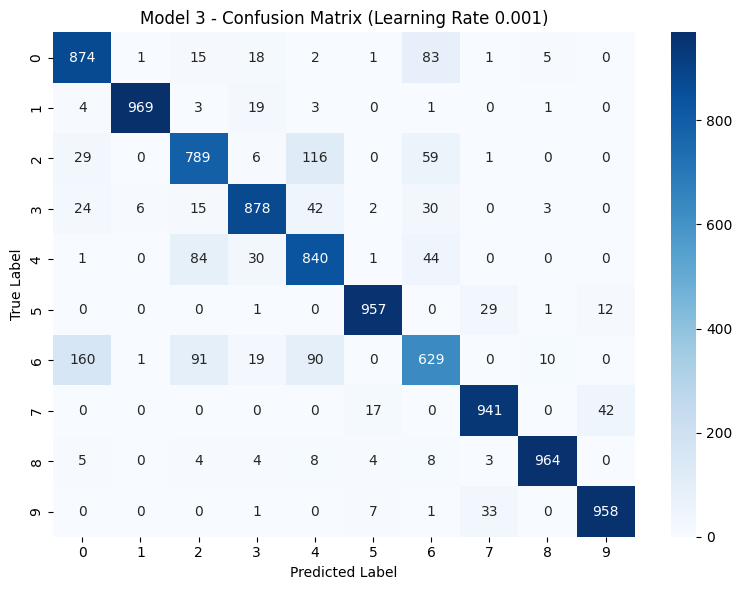

In [50]:
# Plotting results for all trained models
import os

# Create a directory to save images if it doesn't exist
os.makedirs("images", exist_ok=True)

for learning_rate, models_data in results.items():
    for model_name, metrics in models_data.items():
        # Plot training and validation losses
        plt.figure(figsize=(10, 4))
        plt.plot(metrics["train_losses"], label="Training Loss")
        plt.plot(metrics["val_losses"], label="Validation Loss")
        plt.title(f"{model_name} - Loss Curve (Learning Rate {learning_rate})")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"images/{model_name}-{learning_rate}-loss.png", format="png")
        plt.show()

        # Display the confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics["conf_matrix"], annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} - Confusion Matrix (Learning Rate {learning_rate})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.savefig(f"images/{model_name}-{learning_rate}-conf.png", format="png")
        plt.show()


# **Choose Best Model**

In [69]:
# BEST MODEL DEFINITION AND TRAINING

# Define the specifications for the best model
best_model_specs = [
    {'type': 'Dense', 'params': {'input_dim': 784, 'output_dim': 256}},
    {'type': 'BatchNorm', 'params': {'dim': 256}},
    {'type': 'ReLU', 'params': {}},
    {'type': 'Dropout', 'params': {'rate': 0.3}},
    {'type': 'Dense', 'params': {'input_dim': 256, 'output_dim': 128}},
    {'type': 'BatchNorm', 'params': {'dim': 128}},
    {'type': 'ReLU', 'params': {}},
    {'type': 'Dropout', 'params': {'rate': 0.3}},
    {'type': 'Dense', 'params': {'input_dim': 128, 'output_dim': 10}},
    {'type': 'Softmax', 'params': {}}
]

# Initialize the best model
best_model = NeuralNetworkDynamic(best_model_specs, learning_rate=0.0035)

# Train the best model
best_model_results = train(
    best_model, X_train, y_train, X_val, y_val,
    batch_size=batch_size,
    epochs=epochs
)


1 & 0.5486 & 0.8828 & 0.3995 & 0.8535 & 0.8531 \\
2 & 0.4130 & 0.8750 & 0.3638 & 0.8622 & 0.8598 \\
3 & 0.3762 & 0.8984 & 0.3251 & 0.8805 & 0.8782 \\
4 & 0.3512 & 0.9297 & 0.3428 & 0.8722 & 0.8746 \\
5 & 0.3360 & 0.9062 & 0.3213 & 0.8834 & 0.8829 \\
6 & 0.3169 & 0.9141 & 0.3005 & 0.8894 & 0.8895 \\
7 & 0.3046 & 0.9297 & 0.3040 & 0.8903 & 0.8901 \\
8 & 0.2977 & 0.8750 & 0.3164 & 0.8848 & 0.8847 \\
9 & 0.2894 & 0.8984 & 0.3163 & 0.8866 & 0.8878 \\
10 & 0.2842 & 0.8984 & 0.2886 & 0.8950 & 0.8946 \\


# **Save the model with pickle file**

In [70]:
# SAVE MODEL

with open('1905107.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [71]:
# LOAD AND TEST MODEL

# Load the saved model from a file
with open('1905107.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Test the loaded model
test_results = test(loaded_model, X_test, y_test)

# Print the test results
test_loss, test_acc, conf_matrix = test_results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Test Loss: 0.3256
Test Accuracy: 0.8833
Confusion Matrix:
[[807   1  20  38   7   0 116   1  10   0]
 [  2 967   1  23   4   0   2   0   1   0]
 [ 10   0 834  14  93   0  49   0   0   0]
 [ 17   2  15 912  33   0  15   0   6   0]
 [  1   0  98  27 840   0  34   0   0   0]
 [  0   0   0   0   0 945   0  25   2  28]
 [ 98   1 105  35 102   0 648   0  11   0]
 [  0   0   0   0   0  18   0 923   0  59]
 [  2   0   3   6   2   1   1   4 981   0]
 [  0   0   0   0   0   5   1  18   0 976]]


In [72]:
# SAVE MODEL WEIGHTS

# Save the state dictionary of the best model to a file
with open('model_weights.pkl', 'wb') as file:
    pickle.dump(best_model.state_dict(), file)

print("Model weights have been saved to 'model_weights.pkl'.")


Model weights have been saved to 'model_weights.pkl'.


# **Load weights from Pickle file**

In [73]:
# Initialize the test model with the same architecture as the best model
test_model = NeuralNetworkDynamic(best_model_specs, learning_rate=0.0035)

# Load the model weights from the file
with open('model_weights.pkl', 'rb') as file:
    model_weights = pickle.load(file)

# Load the weights into the model
for i, layer in enumerate(test_model.layers):
    if isinstance(layer, DenseLayer):
        if f'layer{i}_weights' in model_weights:
            layer.weight_matrix = model_weights[f'layer{i}_weights']
        if f'layer{i}_bias' in model_weights:
            layer.bias_vector = model_weights[f'layer{i}_bias']

print("Model weights have been successfully loaded into the test model.")


Model weights have been successfully loaded into the test model.


# **Test From Pickle**

In [74]:
# Test the loaded model
test_results_pickle = test(test_model, X_test, y_test)

# Print the test results
test_loss, test_acc, conf_matrix = test_results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Test Loss: 0.3256
Test Accuracy: 0.8833
Confusion Matrix:
[[807   1  20  38   7   0 116   1  10   0]
 [  2 967   1  23   4   0   2   0   1   0]
 [ 10   0 834  14  93   0  49   0   0   0]
 [ 17   2  15 912  33   0  15   0   6   0]
 [  1   0  98  27 840   0  34   0   0   0]
 [  0   0   0   0   0 945   0  25   2  28]
 [ 98   1 105  35 102   0 648   0  11   0]
 [  0   0   0   0   0  18   0 923   0  59]
 [  2   0   3   6   2   1   1   4 981   0]
 [  0   0   0   0   0   5   1  18   0 976]]
